In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import nltk
from wordcloud import WordCloud


In [2]:
df=pd.read_csv('english_dataset.tsv',sep='\t')

In [3]:
df.head(15)

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE
5,hasoc_en_6,@kellymiller513 @TheRealOJ32 I hope you rememb...,NOT,NONE,NONE
6,hasoc_en_7,@ICC Latest design of #WC2019 trophy. #CWC2019...,NOT,NONE,NONE
7,hasoc_en_8,#ADOS #trendingnow #blacklivesmatter #justice ...,HOF,PRFN,TIN
8,hasoc_en_9,Thanks for your support! Wow 600k. Graffiti ha...,NOT,NONE,NONE
9,hasoc_en_10,By wearing the #BalidaanBadge over his gloves ...,NOT,NONE,NONE


### About the Target Variables:
**task_1:** Classiﬁcation of Hate Speech (HOF) and non-hate/offensive content.

**task_2:** If the post is HOF, task_2 is used to classify it as either hate speech (HATE), offensive content (OFFN) or profanity (PRFN).

**task_3:** It decides the target of the post, i.e., targeted insult (TIN) or untargeted (UNT).

# Preprocessing

In [4]:
df=df.drop("text_id", axis=1)

Removed the column "text_id" as it is of no significance.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5852 non-null   object
 1   task_1  5852 non-null   object
 2   task_2  5852 non-null   object
 3   task_3  5852 non-null   object
dtypes: object(4)
memory usage: 183.0+ KB


#### Checking for Missing Values

In [6]:
df.isna().sum()

text      0
task_1    0
task_2    0
task_3    0
dtype: int64

There are no missing values.

In [7]:
from nltk.corpus import stopwords

In [8]:
nltk.download('stopwords')
eng_stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /Users/abc/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/abc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

### Cleaning Tweets: Removing special characters, converting all letters to lowercase, removing stopwords and lemmatizing.

In [23]:
def process_tweet(tweets):
    # remove all the special characters
    new_tweets = re.sub("[^a-zA-Z]", " ",tweets) 
    # convert all letters to lower case
    words = tweets.lower().split()
    # remove stopwords
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer 
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

In [24]:
df['clean_tweets']=df['text'].apply(lambda x: process_tweet(x))

In [13]:
df.head(10)

,text,task_1,task_2,task_3,clean_tweets
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,#dhonikeepstheglove | watch: sport minister ki...
1,@politico No. We should remember very clearly ...,HOF,HATE,TIN,@politico no. remember clearly #individual1 ad...
2,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,@cricketworldcup guess would winner #cwc19? te...
3,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,corbyn politically intellectual #borisjohnsons...
4,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,best #teamindia another swimming competition s...
5,@kellymiller513 @TheRealOJ32 I hope you rememb...,NOT,NONE,NONE,@kellymiller513 @therealoj32 hope remembered w...
6,@ICC Latest design of #WC2019 trophy. #CWC2019...,NOT,NONE,NONE,@icc latest design #wc2019 trophy. #cwc2019 #c...
7,#ADOS #trendingnow #blacklivesmatter #justice ...,HOF,PRFN,TIN,#ados #trendingnow #blacklivesmatter #justice ...
8,Thanks for your support! Wow 600k. Graffiti ha...,NOT,NONE,NONE,thanks support! wow 600k. graffiti massive imp...
9,By wearing the #BalidaanBadge over his gloves ...,NOT,NONE,NONE,wearing #balidaanbadge glove @msdhoni shown lo...


# Exploratory Data Analysis

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


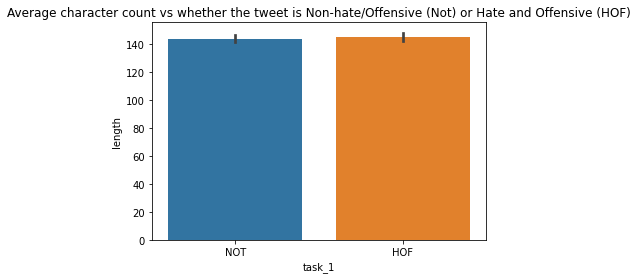

In [14]:
df['length'] =  df['clean_tweets'].apply(len)
fig1 = sns.barplot('task_1', 'length', data= df)
plt.title('Average character count vs whether the tweet is Non-hate/Offensive (Not) or Hate and Offensive (HOF)')
plt.show()

Hence, there is no relation between the character count and type of tweet.

### Checking the distribution of samples (i.e, checking for class imbalance)

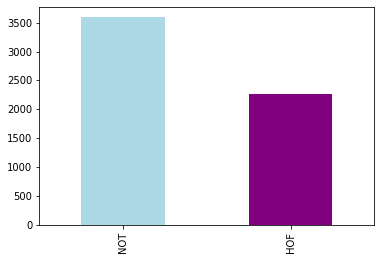

In [15]:
df.task_1.value_counts().plot(kind="bar", color=[ "lightblue", "purple"]);

Clearly, we have an **unbalanced target column.**

This needs to be taken into consideration while training the model.

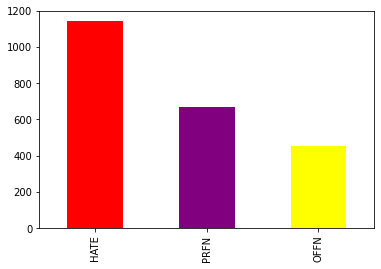

In [16]:
df_hof = df[df["task_1"]=="HOF"]

df_hof.task_2.value_counts().plot(kind="bar", color=[ "red", "purple", "yellow"]);

Majority of the HOF tweets are **hate** tweets followed by tweets containing profanity and offensive content. 

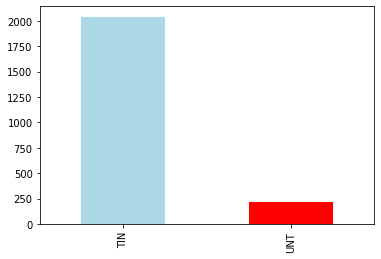

In [17]:
df_hof.task_3.value_counts().plot(kind="bar", color=["lightblue", "red", "lightgreen"]);

Most of the hate and offensive tweets are **targeted insults** and only about 12.5% are untargeted.

In [18]:
hof_tweets= df_hof.clean_tweets
hof_words = ' '.join(hof_tweets)

### Plotting the wordcloud for the words that appear the most in hate and offensive tweets

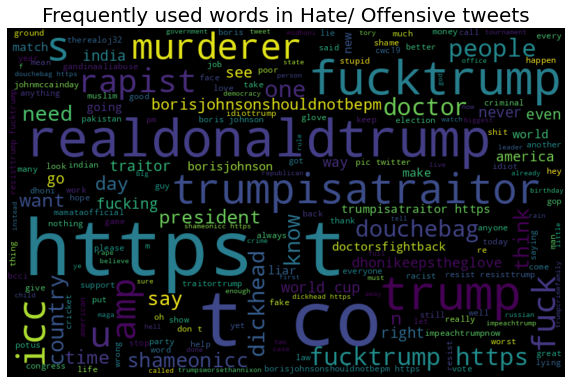

In [19]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hof_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Frequently used words in Hate/ Offensive tweets', size=20)
plt.axis('off')
plt.show()

<AxesSubplot:>

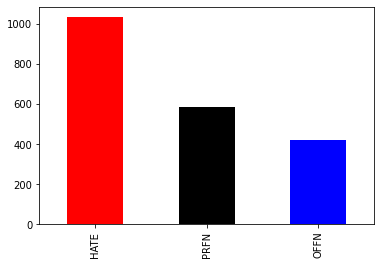

In [20]:
df_tin=df[df["task_3"]=="TIN"]
df_tin.task_2.value_counts().plot(kind="bar",color=["red","black","blue"])

### This Plot shows the Hate Profanity against Targeted Units.

<AxesSubplot:>

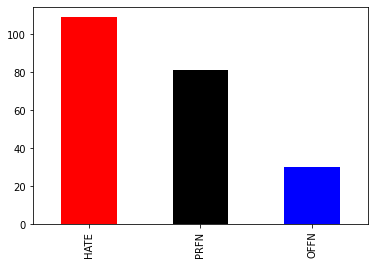

In [21]:
df_unt=df[df["task_3"]=="UNT"]
df_unt.task_2.value_counts().plot(kind="bar",color=["red","black","blue"])

### This Plot shows the Hate Profanity and Offensive tweets against Untargeted units.

It is evident that Profanity to Hate ratio against untargeted units is greater than that of targeted units.

In [25]:
words_in_tweet = [tweet.lower().split() for tweet in df["clean_tweets"]]
words_in_tweet[:2]


[['#dhonikeepstheglove',
  '|',
  'watch:',
  'sport',
  'minister',
  'kiren',
  'rijiju',
  'issue',
  'statement',
  'backing',
  'm',
  'dhoni',
  "'balidaan",
  "badge',",
  'tell',
  'bcci',
  'take',
  'matter',
  'icc',
  'keep',
  'government',
  'know',
  "nation's",
  'pride',
  'involved',
  'https://t.co/zuo5335rjr'],
 ['@politico',
  'no.',
  'remember',
  'clearly',
  '#individual1',
  'admitted',
  'treason',
  '.',
  '#trumpisatraitor',
  '#mccainsahero',
  '#johnmccainday']]

In [31]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)


[('#fucktrump', 1112),
 ('#trumpisatraitor', 854),
 ('@realdonaldtrump', 692),
 ('#doctorsfightback', 670),
 ('#shameonicc', 568),
 ('#dhonikeepstheglove', 557),
 ('@icc', 439),
 ('&amp;', 406),
 ('trump', 398),
 ('#borisjohnsonshouldnotbepm', 388),
 ('doctor', 373),
 ('#murderer', 315),
 ('like', 306),
 ('world', 289),
 ('-', 289)]

In [32]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                                    columns=['words', 'count'])

clean_tweets_no_urls.head()


,words,count
0,#fucktrump,1112
1,#trumpisatraitor,854
2,@realdonaldtrump,692
3,#doctorsfightback,670
4,#shameonicc,568


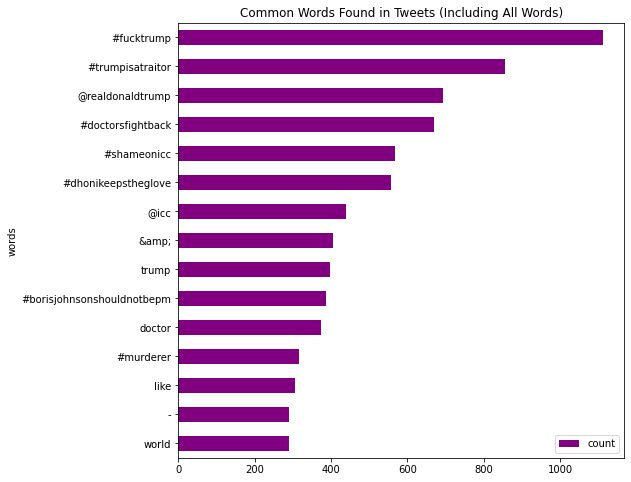

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                                                       y='count',
                                                       ax=ax,
                                                       color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
